In [3]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
torch.manual_seed(3407) 

#%matplotlib inline
#%config InlineBackend.figure_format='retina'

#RANDOM_SEED = 42

#sns.set(style='whitegrid', palette='muted', font_scale=1.2)
#HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
#sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
#rcParams['figure.figsize'] = 12, 8

#pl.seed_everything(RANDOM_SEED)

# Загрузка данных

In [ ]:
toys_df = pd.read_json(r"C:\Users\ga232\Downloads\dataset\Toys_and_Games\Toys_and_Games.json",
                       lines=True)[["reviewText","class"]].drop_duplicates().dropna()
Sports_and_Outdoors_df = pd.read_json(r"C:\Users\ga232\Downloads\dataset\Sports_and_Outdoors\Sports_and_Outdoors.json",
                       lines=True)[["reviewText","class"]].drop_duplicates().dropna()

Home_and_Kitchen_df = pd.read_json(r"C:\Users\ga232\Downloads\dataset\Home_and_Kitchen\Home_and_Kitchen.json",
                       lines=True)[["reviewText","class"]].drop_duplicates().dropna()
Electronics_df = pd.read_json(r"C:\Users\ga232\Downloads\dataset\Electronics\Electronics.json",
                       lines=True)[["reviewText","class"]].drop_duplicates().dropna()
Clothing_Shoes_and_Jewelry_df = pd.read_json(r"C:\Users\ga232\Downloads\dataset\Clothing_Shoes_and_Jewelry\Clothing_Shoes_and_Jewelry.json",
                       lines=True)[["reviewText","class"]].drop_duplicates().dropna()
Cell_Phones_and_Accessories_df = pd.read_json(r"C:\Users\ga232\Downloads\dataset\Cell_Phones_and_Accessories\Cell_Phones_and_Accessories.json",
                       lines=True)[["reviewText","class"]].drop_duplicates().dropna()




In [ ]:
Clothing_Shoes_and_Jewelry_df["reviewText"][3]

In [18]:
Clothing_Shoes_and_Jewelry_df

,reviewText,class
0,My 3-yr-old daughter received this as a gift f...,0
1,This was a really cute tutu the only problem i...,1
2,Perfect red tutu for the price. I baught it as...,1
3,Bought it for my daughters first birthday whic...,1
4,This is a great tutu and at a really great pri...,1
...,...,...
5504326,This is a beautiful piece. Sterling silver is ...,1
5504327,Awaresome,1
5504328,"This is a nice separate bottom to have, I can ...",1
5504329,I purchased this onsie because its adjustable ...,1


In [5]:
#df = pd.read_csv(r"C:\Users\ga232\Downloads\dataset\completeSpamAssassin.csv")[["Body","Label"]]
#df1 = pd.read_csv(r"C:\Users\ga232\Downloads\dataset\enronSpamSubset.csv")[["Body","Label"]]
#df2 = pd.read_csv(r"C:\Users\ga232\Downloads\dataset\lingSpam.csv")[["Body","Label"]]

data = pd.concat([toys_df,
                  Sports_and_Outdoors_df,
                  Home_and_Kitchen_df,
                  Electronics_df,
                  Clothing_Shoes_and_Jewelry_df,
                  Cell_Phones_and_Accessories_df],ignore_index=True).dropna().drop_duplicates()
for i in [toys_df,
                  Sports_and_Outdoors_df,
                  Home_and_Kitchen_df,
                  Electronics_df,
                  Clothing_Shoes_and_Jewelry_df,
                  Cell_Phones_and_Accessories_df]:
    del i

In [7]:
data.to_parquet('diplom_data.parquet')

In [6]:
data.shape

(24692768, 2)

In [10]:
data["reviewText"][0]

'I love these felt nursery rhyme characters and scenes.  The quality of the felt is good, and the illustrations are detailed and pretty.  As noted, the figures and scenes are printed on 2 large sheets of flannel and each individual item needs to be cut out.  This process took me 2 hours of tiny cutting.  To me it does not lend itself to a book form but rather laying out the scenes separately or for use on a flannel board.  However, I love the quiet play it offers for my toddler, and as a former Kindergarten teacher, I understand the value of learning rhyme and its connection to future reading.  Overall, delightful product with some work involved.'

In [17]:
data["reviewText"][0]

'I love these felt nursery rhyme characters and scenes.  The quality of the felt is good, and the illustrations are detailed and pretty.  As noted, the figures and scenes are printed on 2 large sheets of flannel and each individual item needs to be cut out.  This process took me 2 hours of tiny cutting.  To me it does not lend itself to a book form but rather laying out the scenes separately or for use on a flannel board.  However, I love the quiet play it offers for my toddler, and as a former Kindergarten teacher, I understand the value of learning rhyme and its connection to future reading.  Overall, delightful product with some work involved.'

In [9]:
data.head(10)

,reviewText,class
0,I love these felt nursery rhyme characters and...,1
1,I see no directions for its use. Therefore I h...,0
2,This is a great tool for any teacher using the...,1
3,"Great product, thank you! Our son loved the pu...",1
4,Although not as streamlined as the Algebra I m...,1
5,i am glad to get it after 25 yr of waiting for...,1
6,My son got this book for his birthday. He lov...,0
7,Love the book format. My 4yr old grandson love...,0
8,On the plus side - puzzle book format and deli...,0
9,This puzzle is poorly made. The picture part ...,0


In [2]:
data = pd.read_parquet('diplom_data.parquet')

In [3]:
sum(data["class"]==0)

5514604

In [4]:
data[data["class"]==0].iloc[:5514604]

,reviewText,class
1,I see no directions for its use. Therefore I h...,0
6,My son got this book for his birthday. He lov...,0
7,Love the book format. My 4yr old grandson love...,0
8,On the plus side - puzzle book format and deli...,0
9,This puzzle is poorly made. The picture part ...,0
...,...,...
25204889,Its impossible to put on &#62;:( And I'll prob...,0
25204908,Unboxing:I received a review unit from Zerolem...,0
25204931,the main reason i got the case was for the bet...,0
25204943,Not compatible with iPhones or ipads,0


In [5]:
data = pd.concat([data[data["class"]==0],data[data["class"]==1].iloc[:5514604]],ignore_index=True)

In [6]:
np.random.seed(0)

In [ ]:
#data = data.iloc[list(set(np.random.randint(11029208,size=10000000)))]

In [8]:
data = data.reset_index().drop("index",axis=1)

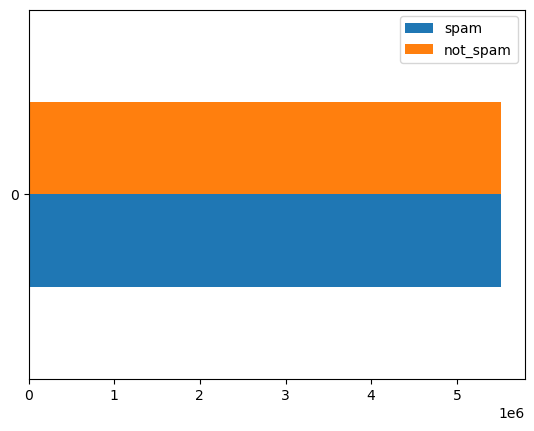

In [9]:
pd.DataFrame(dict(
  spam=[data["class"].sum()], 
  not_spam=[len(data)-data["class"].sum()]
)).plot(kind='barh');

In [11]:
data = data.rename(columns={"reviewText" :"Body","class":"Label"})

# Чистка слов и их дальнейшая токенизация 

In [ ]:
from nltk.tokenize import word_tokenize 
import nltk
import re 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer 

In [13]:
data['Body']

0           i see no directions for its use. therefore i h...
1           my son got this book for his birthday.  he lov...
2           love the book format. my 4yr old grandson love...
3           on the plus side - puzzle book format and deli...
4           this puzzle is poorly made.  the picture part ...
                                  ...                        
11029203    bought this to weigh hiking gear.  works reall...
11029204    we were originally going to get another scale ...
11029205    for anyone who works out and wants to have a g...
11029206    this scale works just like it's supposed to, a...
11029207    i am a retired chemist and spent all of my wor...
Name: Body, Length: 11029208, dtype: object

In [29]:
data['Body']

0           i see no directions for its use. therefore i h...
1           my son got this book for his birthday.  he lov...
2           love the book format. my 4yr old grandson love...
3           on the plus side - puzzle book format and deli...
4           this puzzle is poorly made.  the picture part ...
                                  ...                        
11029203    bought this to weigh hiking gear.  works reall...
11029204    we were originally going to get another scale ...
11029205    for anyone who works out and wants to have a g...
11029206    this scale works just like it's supposed to, a...
11029207    i am a retired chemist and spent all of my wor...
Name: Body, Length: 11029208, dtype: object

In [12]:
data['Body'] = data['Body'].str.lower()
stopwords_set = set(stopwords.words('english'))
data['Body'] = data['Body'].apply(lambda x: ' '.join([word for word in nltk.word_tokenize(x) if word not in stopwords_set]))
#data['Body'] = data['Body'].apply(lambda x: re.sub('[^\w\s]', '', x))

KeyboardInterrupt: 

In [ ]:
data.to_parquet('train_test_data.parquet')

In [31]:
data = data.iloc[list(set(np.random.randint(11029208,size=3000000)))]

In [4]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [14]:
data["Body"] = data["Body"].apply(lambda x:tokenizer.encode_plus(
  x,
  add_special_tokens=True,
  max_length=200,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)["input_ids"][0][:200])

In [15]:
data = data.reset_index().drop("index",axis=1)

In [16]:
data["Body"] = data["Body"].apply(lambda x: x.numpy())

In [18]:
data

,Body,Label
0,"[101, 146, 1267, 1185, 7768, 1111, 1157, 1329,...",0
1,"[101, 1422, 1488, 1400, 1142, 1520, 1111, 1117...",0
2,"[101, 2185, 1103, 1520, 3536, 119, 1422, 125, ...",0
3,"[101, 1212, 1103, 4882, 1334, 118, 13544, 1520...",0
4,"[101, 1188, 13544, 1110, 9874, 1189, 119, 1109...",0
...,...,...
11029203,"[101, 9326, 11266, 1142, 1106, 18678, 14249, 6...",1
11029204,"[101, 1284, 1127, 2034, 1280, 1106, 1243, 1330...",1
11029205,"[101, 1370, 2256, 1150, 1759, 1149, 1105, 3349...",1
11029206,"[101, 1188, 3418, 1759, 1198, 1176, 1122, 112,...",1


In [19]:
data.to_pickle('train_test_data1.pkl')

In [17]:
data = pd.read_pickle('train_test_data1.pkl')


In [18]:
data["Body"] = data["Body"].apply(lambda x: x[:200])

# Cоздание Dataloader

In [19]:
data["len"] = data["Body"].apply(lambda x: len(x))

In [20]:
train_df, test_df = train_test_split(data,train_size = 0.8,random_state=42)


In [21]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, data):
        #self.data = data.reset_index().drop("index",axis=1).to_numpy()
        self.X = data["Body"].to_numpy()
        self.y = data["Label"].to_numpy()
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return  self.X[idx], self.y[idx],

In [22]:
train_dataset = TextDataset(train_df)
test_dataset = TextDataset(test_df)

train_loader = DataLoader(train_dataset,batch_size=768,pin_memory = True)
valid_loader = DataLoader(test_dataset,batch_size=64,pin_memory = True)

# Пишем трансформер

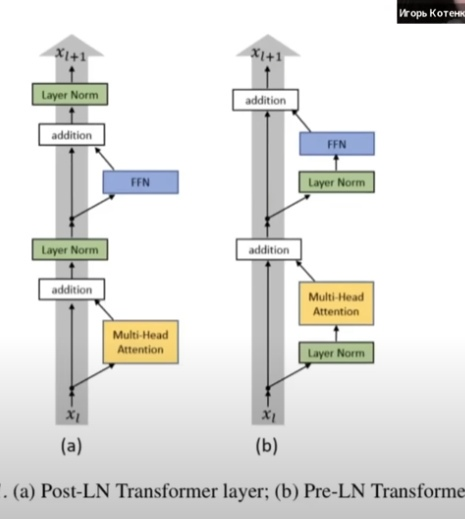

In [23]:
from torch.nn import functional as F

def scale_dot_product(q,k,v):
    d_k = q.size()[-1]#200x512x192
    scaled = q@k.transpose(-1,-2)*d_k**(-0.5)# 200x512x512
    attention = F.softmax(scaled, dim=-1)
    values = attention@v
    return values,attention
    
class PositionwiseFeedForward(nn.Module):
    def __init__(self,d_model, ffn_hidden , drop_prob):
        super().__init__()
        self.linear1 = nn.Linear(d_model,ffn_hidden)
        self.dropout1 = nn.Dropout(drop_prob)
        self.gelu = nn.GELU()
        self.linear2 = nn.Linear(ffn_hidden, d_model)
        
    def forward(self,x):
        x = self.dropout1(self.gelu(self.linear1(x)))
        return self.linear2(x)
    
class MultiHeadAttention(nn.Module):
    def __init__(self,d_model,n_heads):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model//n_heads
        self.qkv = nn.Linear(d_model, d_model*3)
        self.linear = nn.Linear(d_model, d_model)
        
    def forward(self,x):#
        batch_size, sequence_length, d_model = x.size()
        qkv = self.qkv(x)#200x512x1536
        qkv = qkv.reshape(batch_size,sequence_length,self.n_heads, self.head_dim*3).permute(0,2,1,3)
        q,k,v = qkv.chunk(3,dim=-1)#
        values, attention = scale_dot_product(q,k,v)
        values = values.permute(0,2,1,3).reshape(batch_size,sequence_length,d_model)
        return self.linear(values)

class Block(nn.Module):
    def __init__(self,d_model, n_heads,drop_prob):
        super().__init__()
        self.attention = MultiHeadAttention(d_model,n_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(drop_prob)
        self.ffn = PositionwiseFeedForward(d_model=d_model, ffn_hidden=d_model*3, drop_prob=drop_prob)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(p=drop_prob)
        
    def forward(self, x):# 64x200x512
        x = x + self.attention(self.norm1(self.dropout(x)))
        x = x + self.ffn(self.norm2(self.dropout(x)))
        return x
    

class ScratchTransformer(nn.Module):
    def __init__(self,d_model,n_layers,n_heads,dropout,max_len,n_out):
        super().__init__()
        self.d_model = d_model
        self.pos_vect = torch.LongTensor([i for i in range(max_len)]).to(device)
        
        self.token_embedding_table = nn.Embedding(tokenizer.vocab_size, d_model, padding_idx=0)
        self.pos_embedding_table = nn.Embedding(max_len, d_model)
        self.blocks = nn.Sequential(*[Block(d_model, n_heads=n_heads,drop_prob=dropout) for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(d_model) # final layer norm

        self.classifier = nn.Sequential(*[nn.Linear(d_model*max_len, d_model),
                                          nn.BatchNorm1d(d_model),
                                          nn.Dropout(dropout),
                                          nn.GELU(),
                                          nn.Linear(d_model,n_out),
                                          nn.Sigmoid()
                                         ])
                                          
                                                    
    def forward(self,x):
        x = self.token_embedding_table(x) +  self.pos_embedding_table(self.pos_vect)
        x = self.blocks(x)
        x = self.ln_f(x)

        x = x.reshape(x.size()[0],-1)
        x = self.classifier(x)
        return x
        
        
        

# Функции для обучения




In [24]:
from IPython.display import clear_output
from tqdm import tqdm


def train(model) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device).float()

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output.squeeze(0), y.unsqueeze(1))

        train_loss += loss.item()

        loss.backward()

        optimizer.step()
        
        #_, y_pred = torch.max(output, 1)
        y_pred = torch.round(output)
        total += y.size(0)
        #correct += (y_pred == y).sum().item()
        correct += (y_pred.reshape(-1) == y).sum().item()
    print(total,correct)
    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()
    

        
@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device).float()

        output = model(x)

        loss = loss_fn(output.squeeze(0), y.unsqueeze(1))

        total_loss += loss.item()

        #_, y_pred = torch.max(output, 1)
        y_pred = torch.round(output)
        total += y.size(0)
        #correct += (y_pred == y).sum().item()
        correct += (y_pred.reshape(-1) == y).sum().item()
    total_loss /= len(loader)
    accuracy = correct / total #total

    return total_loss, accuracy


def whole_train_valid_cycle_with_scheduler(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )
        if valid_loss_history[-1] == min(valid_loss_history):
            torch.save(model.state_dict(), "model3_.pt")

        scheduler.step()

In [25]:
min([1,2,3])

1

In [26]:
from torch.optim.lr_scheduler import StepLR
device = "cuda"
model = ScratchTransformer(90,6,6,0.15,200,1).to("cuda")

optimizer = torch.optim.RAdam(model.parameters(),
                 lr = 1e-4)
scheduler = StepLR(optimizer, step_size=25)
loss_fn = nn.functional.binary_cross_entropy

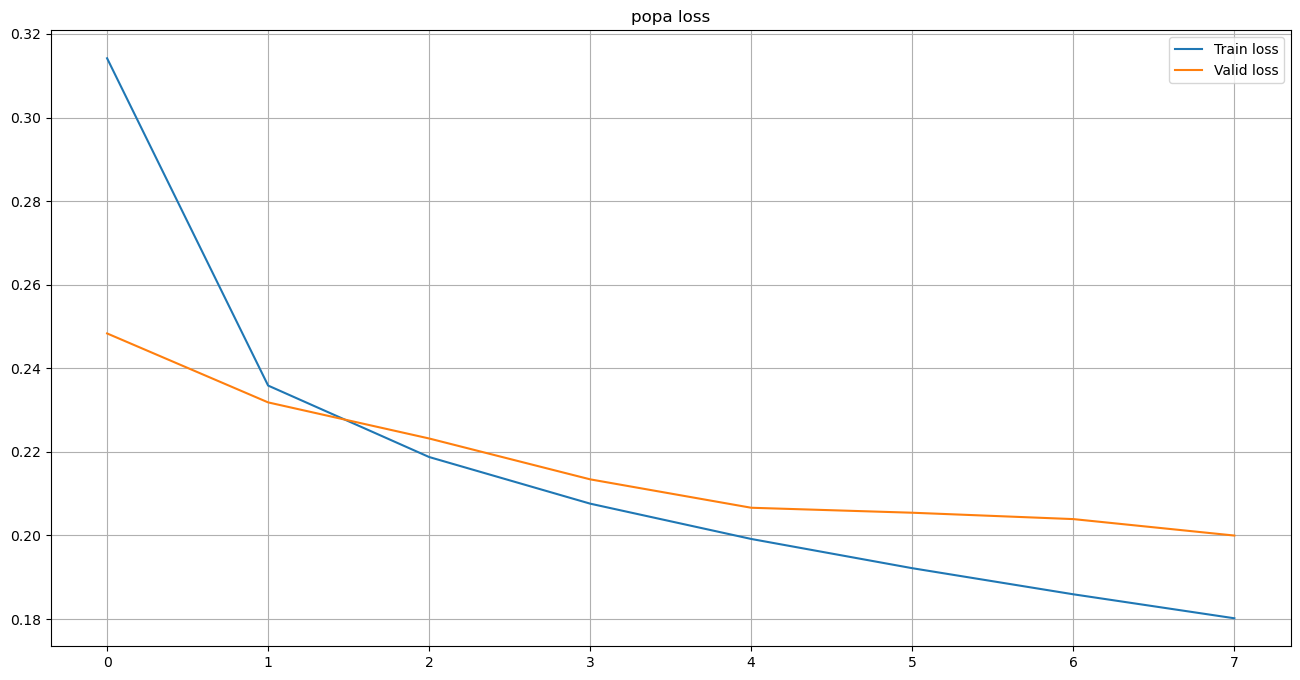

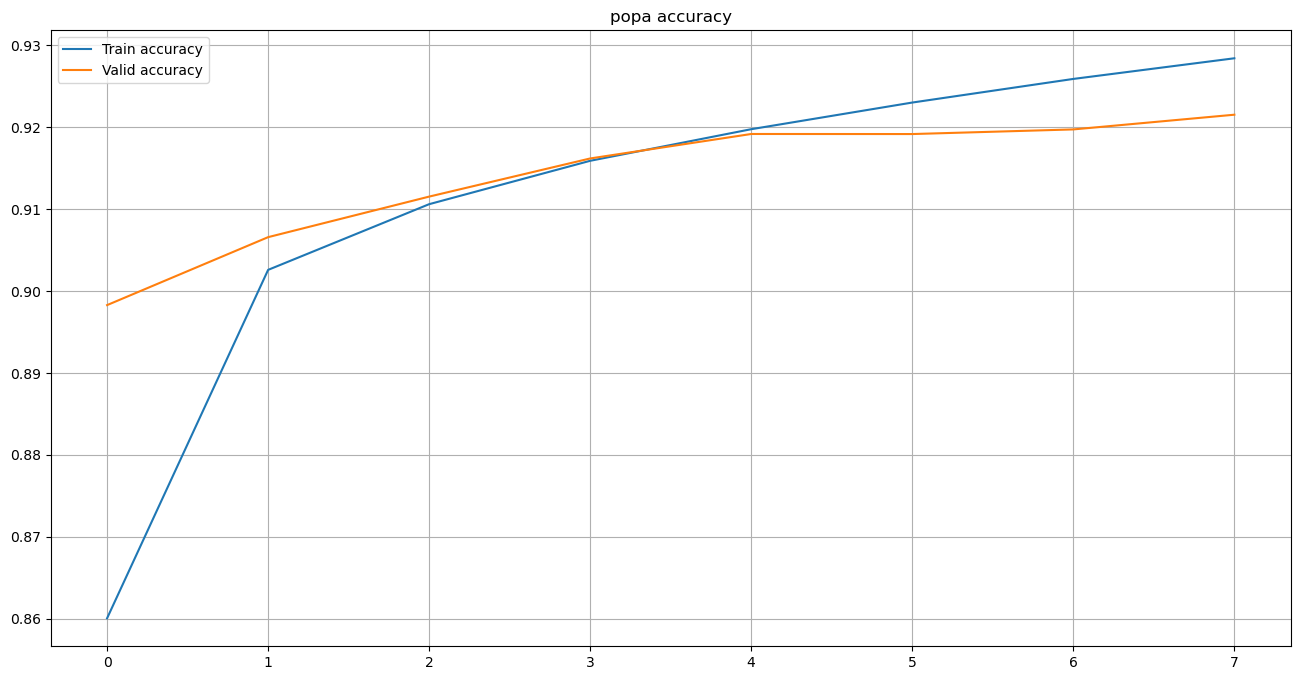

Train:  31%|█████████████████████▎                                                | 3506/11489 [19:09<43:37,  3.05it/s]


KeyboardInterrupt: 

In [27]:
whole_train_valid_cycle_with_scheduler(model,50,"popa" )

In [ ]:
torch.save(model.state_dict(), "model3_auc_97.pt")

In [12]:
model.load_state_dict(torch.load("model3_auc_97.pt"))

FileNotFoundError: [Errno 2] No such file or directory: 'model_2.pt'

In [14]:
model.eval()

ScratchTransformer(
  (token_embedding_table): Embedding(28996, 90, padding_idx=0)
  (pos_embedding_table): Embedding(200, 90)
  (blocks): Sequential(
    (0): Block(
      (attention): MultiHeadAttention(
        (qkv): Linear(in_features=90, out_features=270, bias=True)
        (linear): Linear(in_features=90, out_features=90, bias=True)
      )
      (norm1): LayerNorm((90,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.15, inplace=False)
      (ffn): PositionwiseFeedForward(
        (linear1): Linear(in_features=90, out_features=270, bias=True)
        (dropout1): Dropout(p=0.15, inplace=False)
        (gelu): GELU(approximate='none')
        (linear2): Linear(in_features=270, out_features=90, bias=True)
      )
      (norm2): LayerNorm((90,), eps=1e-05, elementwise_affine=True)
      (dropout2): Dropout(p=0.15, inplace=False)
    )
    (1): Block(
      (attention): MultiHeadAttention(
        (qkv): Linear(in_features=90, out_features=270, bias=True)
        (

In [23]:
x,y = next(iter(valid_loader))
model(x.to("cuda")).reshape(-1).cpu().detach().numpy()

array([9.9874854e-01, 4.5186467e-03, 9.8405159e-01, 5.5174279e-01,
       7.6304637e-02, 8.3066815e-01, 5.6164805e-02, 2.2473919e-01,
       8.2726851e-03, 8.7618470e-01, 2.6440825e-02, 2.9037166e-01,
       6.0809278e-03, 1.6215770e-03, 9.1826373e-01, 9.9857259e-01,
       9.3308449e-01, 2.7653580e-03, 9.5233601e-01, 9.9985504e-01,
       9.9583626e-01, 1.6218591e-02, 9.9722630e-01, 2.6216684e-02,
       2.0048855e-01, 9.4493061e-02, 8.9752388e-01, 6.8561316e-01,
       9.9676621e-01, 9.3877208e-01, 6.5612216e-03, 9.9864703e-01,
       2.5445005e-02, 9.7987217e-01, 2.8193852e-05, 9.9344617e-01,
       4.6877079e-02, 9.8367923e-01, 9.8614943e-01, 1.8909426e-02,
       9.6646202e-01, 2.6536602e-01, 6.9692814e-01, 9.8732263e-01,
       1.3387449e-03, 2.4951417e-03, 5.8621281e-01, 9.7713363e-01,
       7.2633547e-01, 8.4321618e-01, 9.9948645e-01, 2.0014457e-03,
       5.0789330e-02, 4.0861946e-03, 9.7758543e-01, 1.6924923e-02,
       1.1295364e-03, 4.5016226e-01, 9.9553668e-01, 1.1727459e

In [28]:
model.eval()

y_pred = np.array([])
y_true = np.array([])
for x,y in tqdm(valid_loader, desc='Evaluation'):
    x, y = x.to(device), y.to(device).float()

    y_pred = np.append(y_pred,model(x).reshape(-1).cpu().detach().numpy())
    y_true = np.append(y_true,y.cpu().detach().numpy())

Evaluation: 100%|████████████████████████████████████████████████████████████████| 34467/34467 [10:03<00:00, 57.12it/s]


In [29]:
y_true.shape

(525257,)

In [29]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true,y_pred)

0.9772902259659156

In [29]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true,y_pred)

0.9732440317543725

In [32]:
roc_auc_score(y_true,y_pred)

0.9677197622026245

In [39]:
roc_auc_score(y_true,y_pred)

0.9638466200481646

In [45]:
roc_auc_score(y_true,y_pred)

0.9679945684097171

In [1]:
! nvidia-smi

Tue Jan  9 07:54:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.33                 Driver Version: 546.33       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080 Ti   WDDM  | 00000000:01:00.0  On |                  N/A |
| 59%   36C    P8              29W / 350W |    781MiB / 12288MiB |     10%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--